## Loading Packages

In [ ]:
!pip install -q transformers
!pip install -q torchinfo
!pip install -U -q datasets fsspec huggingface_hub
!pip install -q evaluate

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import transformers
import evaluate

from datasets import load_dataset
from torchinfo import summary

from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AutoConfig
from transformers import TrainingArguments, Trainer

from typing import Dict, Any
import copy

## Dataset preparation

In [ ]:
imdb_dataset = load_dataset("imdb")

train_tiny = imdb_dataset['train'].shuffle().select(range(100))
train_small = imdb_dataset['train'].shuffle().select(range(1000))
train_medium = imdb_dataset['train'].shuffle().select(range(5000))
train_large = imdb_dataset['train'].shuffle().select(range(10000))


test_tiny = imdb_dataset['test'].shuffle().select(range(100))
test_small = imdb_dataset['test'].shuffle().select(range(1000))
test_medium = imdb_dataset['test'].shuffle().select(range(5000))
test_large = imdb_dataset['test'].shuffle().select(range(10000))

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
MAX_SEQUENCE_LENGTH = 100

def preprocess_imdb(data, tokenizer):
    review_text = data['text']

    encoded = tokenizer.batch_encode_plus(
            review_text,
            max_length=MAX_SEQUENCE_LENGTH,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_token_type_ids=True,
            return_tensors="pt"
        )

    return encoded

In [ ]:
rte_dataset = load_dataset("glue", "rte")

README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/584k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/621k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2490 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/277 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3000 [00:00<?, ? examples/s]

In [ ]:
def preprocess_rte(examples, tokenizer):
    return tokenizer(
        text=examples["sentence1"],
        text_pair=examples["sentence2"],
        padding="max_length",
        truncation=True,
        max_length=256,
        return_tensors='pt' #important, don't get cuda error.
    )

def compute_metrics_rte(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

## Loading Functions

In [ ]:
metric = evaluate.load('accuracy')

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
def fine_tune_classification_model(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   batch_size = 16,
                                   num_epochs = 2,
                                   output_dir="bert_fine_tuned_imdb"):
    """
    Fine tune on imdb
    """

    preprocessed_train_data = train_data.map(preprocess_imdb, batched=True, fn_kwargs={'tokenizer': tokenizer})
    preprocessed_dev_data = dev_data.map(preprocess_imdb, batched=True, fn_kwargs={'tokenizer': tokenizer})

    training_args = TrainingArguments(
                                      output_dir=output_dir,
                                      per_device_train_batch_size=batch_size,
                                      per_device_eval_batch_size=batch_size,
                                      num_train_epochs=num_epochs,
                                      eval_strategy="epoch",
                                      save_strategy="epoch",
                                      report_to='none'
                                      )

    trainer = Trainer(
                      model=classification_model,
                      args=training_args,
                      train_dataset=preprocessed_train_data,
                      eval_dataset=preprocessed_dev_data,
                      compute_metrics=compute_metrics
                      )


    trainer.train()
    return trainer

def fine_tune_classification_model_rte(classification_model,
                                   tokenizer,
                                   train_data,
                                   dev_data,
                                   batch_size=16,
                                   num_epochs=3,
                                   output_dir="bert_fine_tuned_rte"):
    """
    Fine-tune model on RTE dataset
    """
    preprocessed_train_data = train_data.map(
        preprocess_rte,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer}
    )
    preprocessed_dev_data = dev_data.map(
        preprocess_rte,
        batched=True,
        fn_kwargs={'tokenizer': tokenizer}
    )

    training_args = TrainingArguments(
                                      output_dir=output_dir,
                                      per_device_train_batch_size=batch_size,
                                      per_device_eval_batch_size=batch_size,
                                      num_train_epochs=num_epochs,
                                      eval_strategy="epoch",
                                      save_strategy="epoch",
                                      report_to='none'
                                      )

    trainer = Trainer(
        model=classification_model,
        args=training_args,
        train_dataset=preprocessed_train_data,
        eval_dataset=preprocessed_dev_data,
        compute_metrics=compute_metrics_rte
    )

    trainer.train()
    return trainer

In [ ]:
def remove_small_svs(layer, k=0.1):
    '''
    layer = layer number
    k = bottom fraction of svd's to remove.
    '''
    U, s, Vh = torch.linalg.svd(layer.weight)
    keep_count = int(len(s) * (1 - k))
    s_trunc = torch.cat([s[:keep_count], torch.zeros(len(s) - keep_count)])
    return U @ torch.diag(s_trunc) @ Vh

In [ ]:
def remove_svs_decile(linear_layer, decile_to_remove):
    """
    Remove a specific decile of singular values from a linear layer.
    :param linear_layer: nn.Linear module
    :param decile_to_remove: int in [0, 9], where 0 = top 10%, 9 = bottom 10%
    """
    with torch.no_grad():
        W = linear_layer.weight.data
        U, s, Vh = torch.linalg.svd(W.float(), full_matrices=False)

        n = len(s)
        decile_size = n // 10
        start = decile_to_remove * decile_size
        end = (decile_to_remove + 1) * decile_size if decile_to_remove < 9 else n

        s_trunc = s.clone()
        s_trunc[start:end] = 0

        W_trunc = U @ torch.diag(s_trunc) @ Vh
        linear_layer.weight.data = W_trunc.to(W.dtype)



def remove_svs_from_bert_decile(model, decile_to_remove, layer_type="all"):
    #removing from all layer types.
    for layer in model.bert.encoder.layer:
        if layer_type in ["all", "query"]:
            remove_svs_decile(layer.attention.self.query, decile_to_remove)
        if layer_type in ["all", "key"]:
            remove_svs_decile(layer.attention.self.key, decile_to_remove)
        if layer_type in ["all", "value"]:
            remove_svs_decile(layer.attention.self.value, decile_to_remove)
        if layer_type in ["all", "output"]:
            remove_svs_decile(layer.attention.output.dense, decile_to_remove)
        if layer_type in ["all", "ffn"]:
            remove_svs_decile(layer.intermediate.dense, decile_to_remove)
            remove_svs_decile(layer.output.dense, decile_to_remove)


def evaluate_decile_removal(control_model, tokenizer, trainer_args,
                            compute_metrics, test_data, model_checkpoint_name):
    """
    Evaluate validation accuracy after removing each decile of SVs.
    Returns a list of accuracies, one per decile.
    """
    accuracies = []

    for decile in range(10):
        print(f"\n=== Evaluating decile {decile} removal ===")
        #copy model
        treatment_model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name, num_labels=2)
        treatment_model = copy.deepcopy(control_model).cpu()  #avoid cuda errors...


        #remove selected decile
        #note: may need to add params to remove specific layer type!
        remove_svs_from_bert_decile(treatment_model, decile_to_remove=decile, layer_type="all")

        #create new trainer
        treatment_trainer = Trainer(
            model=treatment_model,
            args=trainer_args,
            compute_metrics=compute_metrics,
            eval_dataset=test_data
        )

        #evaluate.
        results = treatment_trainer.evaluate(test_data)
        accuracy = results.get("eval_accuracy", None)
        print(f"Decile {decile} Accuracy: {accuracy:.4f}")
        accuracies.append(accuracy)

    return accuracies

## Training Models

### IMDb

In [ ]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = AutoModel.from_pretrained('bert-base-cased')

#assign model name to variable for convenience
model_checkpoint_name = "bert-base-cased"

#initialize tokenizer using model checkpoint name
bert_tokenizer = AutoTokenizer.from_pretrained(model_checkpoint_name)

#initialize BERT model specifically configured for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

test_processed = test_large.map(preprocess_imdb, batched=True, fn_kwargs={'tokenizer': bert_tokenizer})

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
#6 minutes to run
model_imdb1 = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

trainer_imdb1 = fine_tune_classification_model(model_imdb1, bert_tokenizer, train_medium, test_small,
                               num_epochs=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.359497,0.843000


In [ ]:
accuracies_imdb1 = evaluate_decile_removal(
    control_model=trainer_imdb1.model,
    tokenizer=bert_tokenizer,
    trainer_args=trainer_imdb1.args,
    compute_metrics=trainer_imdb1.compute_metrics,
    test_data=test_processed,
    model_checkpoint_name=model_checkpoint_name
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Evaluating decile 0 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 0 Accuracy: 0.4967

=== Evaluating decile 1 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 1 Accuracy: 0.7479

=== Evaluating decile 2 removal ===


Decile 2 Accuracy: 0.8144

=== Evaluating decile 3 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 3 Accuracy: 0.8267

=== Evaluating decile 4 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 4 Accuracy: 0.8317

=== Evaluating decile 5 removal ===


Decile 5 Accuracy: 0.8305

=== Evaluating decile 6 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 6 Accuracy: 0.8350

=== Evaluating decile 7 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 7 Accuracy: 0.8330

=== Evaluating decile 8 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 8 Accuracy: 0.8356

=== Evaluating decile 9 removal ===


Decile 9 Accuracy: 0.8288


In [ ]:
accuracies_imdb1

[0.4967, 0.7479, 0.8144, 0.8267, 0.8317, 0.8305, 0.835, 0.833, 0.8356, 0.8288]

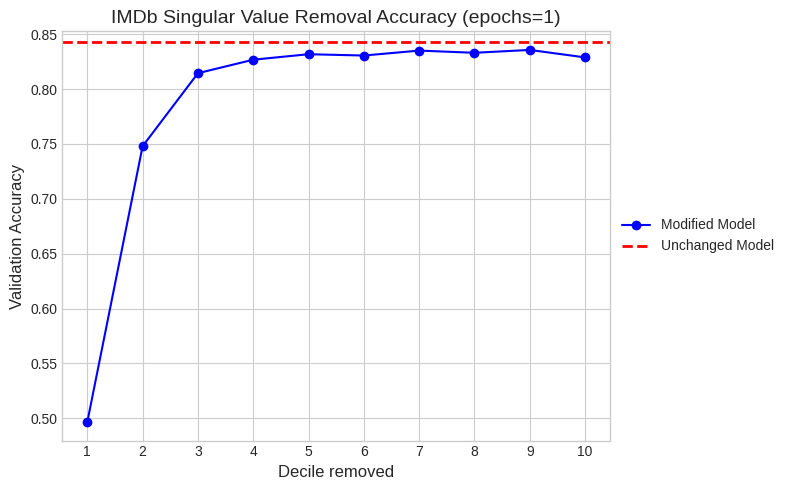

In [ ]:
plt.figure(figsize=(8, 5))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot
final_acc = 0.843000
plt.plot(range(1, len(accuracies_imdb1)+1), accuracies_imdb1, marker='o', label='Modified Model', color='blue')
plt.axhline(y=final_acc, color='red', linestyle='--', linewidth=2, label='Unchanged Model')

# Labels and formatting
plt.xlabel('Decile removed', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('IMDb Singular Value Removal Accuracy (epochs=1)', fontsize=14)
plt.xticks(range(1, len(accuracies_imdb1)+1))
#plt.ylim(0., 1)

# Legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [ ]:
model_imdb2 = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

trainer_imdb2 = fine_tune_classification_model(model_imdb2, bert_tokenizer, train_medium, test_small,
                               num_epochs=2)

accuracies_imdb2 = evaluate_decile_removal(
    control_model=trainer_imdb2.model,
    tokenizer=bert_tokenizer,
    trainer_args=trainer_imdb2.args,
    compute_metrics=trainer_imdb2.compute_metrics,
    test_data=test_processed,
    model_checkpoint_name=model_checkpoint_name
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.408918,0.821000
2,0.432700,0.420259,0.848000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Evaluating decile 0 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 0 Accuracy: 0.4978

=== Evaluating decile 1 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 1 Accuracy: 0.7426

=== Evaluating decile 2 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 2 Accuracy: 0.8163

=== Evaluating decile 3 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 3 Accuracy: 0.8184

=== Evaluating decile 4 removal ===


Decile 4 Accuracy: 0.8222

=== Evaluating decile 5 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 5 Accuracy: 0.8241

=== Evaluating decile 6 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 6 Accuracy: 0.8283

=== Evaluating decile 7 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 7 Accuracy: 0.8277

=== Evaluating decile 8 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 8 Accuracy: 0.8290

=== Evaluating decile 9 removal ===


Decile 9 Accuracy: 0.8289


In [ ]:
print(accuracies_imdb2)

[0.4978, 0.7426, 0.8163, 0.8184, 0.8222, 0.8241, 0.8283, 0.8277, 0.829, 0.8289]


In [ ]:
model_imdb3 = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

trainer_imdb3 = fine_tune_classification_model(model_imdb3, bert_tokenizer, train_medium, test_small,
                               num_epochs=3)

accuracies_imdb3 = evaluate_decile_removal(
    control_model=trainer_imdb3.model,
    tokenizer=bert_tokenizer,
    trainer_args=trainer_imdb3.args,
    compute_metrics=trainer_imdb3.compute_metrics,
    test_data=test_processed,
    model_checkpoint_name=model_checkpoint_name
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.403248,0.814000
2,0.422300,0.381659,0.855000
3,0.422300,0.613214,0.844000



=== Evaluating decile 0 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 0 Accuracy: 0.4964

=== Evaluating decile 1 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 1 Accuracy: 0.7656

=== Evaluating decile 2 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 2 Accuracy: 0.8224

=== Evaluating decile 3 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 3 Accuracy: 0.8224

=== Evaluating decile 4 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 4 Accuracy: 0.8293

=== Evaluating decile 5 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 5 Accuracy: 0.8293

=== Evaluating decile 6 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 6 Accuracy: 0.8344

=== Evaluating decile 7 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 7 Accuracy: 0.8312

=== Evaluating decile 8 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 8 Accuracy: 0.8319

=== Evaluating decile 9 removal ===


Decile 9 Accuracy: 0.8273


In [ ]:
accuracies_imdb3

[0.4964,
 0.7656,
 0.8224,
 0.8224,
 0.8293,
 0.8293,
 0.8344,
 0.8312,
 0.8319,
 0.8273]

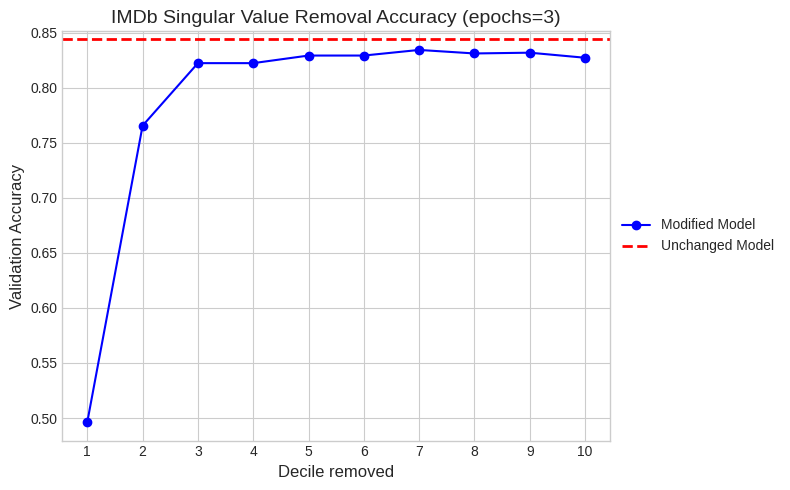

In [ ]:
plt.figure(figsize=(8, 5))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot
final_acc = 0.844000
plt.plot(range(1, len(accuracies_imdb3)+1), accuracies_imdb3, marker='o', label='Modified Model', color='blue')
plt.axhline(y=final_acc, color='red', linestyle='--', linewidth=2, label='Unchanged Model')

# Labels and formatting
plt.xlabel('Decile removed', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('IMDb Singular Value Removal Accuracy (epochs=3)', fontsize=14)
plt.xticks(range(1, len(accuracies_imdb3)+1))
#plt.ylim(0., 1)

# Legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [ ]:
model_imdb10 = AutoModelForSequenceClassification.from_pretrained(model_checkpoint_name)

trainer_imdb10 = fine_tune_classification_model(model_imdb10, bert_tokenizer, train_medium, test_small,
                               num_epochs=10)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.448209,0.785000
2,0.456000,0.435798,0.815000
3,0.456000,0.821230,0.791000
4,0.266200,0.752245,0.819000
5,0.131300,0.875422,0.820000
6,0.131300,0.937578,0.826000
7,0.059400,1.077656,0.820000
8,0.034800,1.048512,0.828000
9,0.034800,1.122064,0.818000
10,0.023000,1.092440,0.821000



=== Evaluating decile 0 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 0 Accuracy: 0.5271

=== Evaluating decile 1 removal ===


Decile 1 Accuracy: 0.4657

=== Evaluating decile 2 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 2 Accuracy: 0.4477

=== Evaluating decile 3 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 3 Accuracy: 0.4404

=== Evaluating decile 4 removal ===


Decile 4 Accuracy: 0.4838

=== Evaluating decile 5 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 5 Accuracy: 0.4404

=== Evaluating decile 6 removal ===


Decile 6 Accuracy: 0.4657

=== Evaluating decile 7 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 7 Accuracy: 0.4513

=== Evaluating decile 8 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 8 Accuracy: 0.4585

=== Evaluating decile 9 removal ===


KeyboardInterrupt: 

In [ ]:
test_processed = test_large.map(preprocess_imdb, batched=True, fn_kwargs={'tokenizer': bert_tokenizer})
accuracies_imdb10 = evaluate_decile_removal(
    control_model=trainer_imdb10.model,
    tokenizer=bert_tokenizer,
    trainer_args=trainer_imdb10.args,
    compute_metrics=trainer_imdb10.compute_metrics,
    test_data=test_processed,
    model_checkpoint_name=model_checkpoint_name
)


=== Evaluating decile 0 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 0 Accuracy: 0.4967

=== Evaluating decile 1 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 1 Accuracy: 0.7960

=== Evaluating decile 2 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 2 Accuracy: 0.8159

=== Evaluating decile 3 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 3 Accuracy: 0.8203

=== Evaluating decile 4 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 4 Accuracy: 0.8212

=== Evaluating decile 5 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 5 Accuracy: 0.8199

=== Evaluating decile 6 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 6 Accuracy: 0.8254

=== Evaluating decile 7 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 7 Accuracy: 0.8212

=== Evaluating decile 8 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 8 Accuracy: 0.8256

=== Evaluating decile 9 removal ===


Decile 9 Accuracy: 0.8271


In [ ]:
accuracies_imdb10

[0.4967, 0.796, 0.8159, 0.8203, 0.8212, 0.8199, 0.8254, 0.8212, 0.8256, 0.8271]

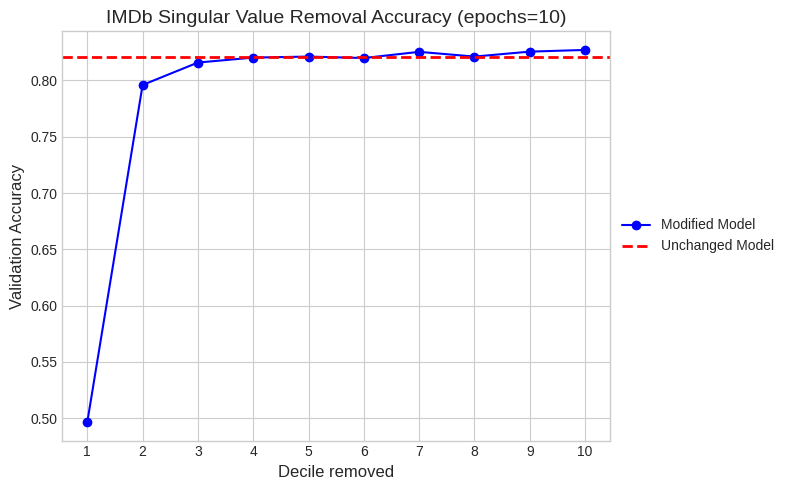

In [ ]:
plt.figure(figsize=(8, 5))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot
final_acc = 0.821000
plt.plot(range(1, len(accuracies_imdb10)+1), accuracies_imdb10, marker='o', label='Modified Model', color='blue')
plt.axhline(y=final_acc, color='red', linestyle='--', linewidth=2, label='Unchanged Model')

# Labels and formatting
plt.xlabel('Decile removed', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('IMDb Singular Value Removal Accuracy (epochs=10)', fontsize=14)
plt.xticks(range(1, len(accuracies_imdb10)+1))
#plt.ylim(0., 1)

# Legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


### RTE (more complicated task and reasoning)

In [ ]:
model_checkpoint = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model3 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2
)

trainer3 = fine_tune_classification_model_rte(
    model3,
    tokenizer,
    train_data=rte_dataset["train"],
    dev_data=rte_dataset["validation"],
    num_epochs=3
)

test_processed = rte_dataset['validation'].map(preprocess_rte, batched=True, fn_kwargs={'tokenizer': tokenizer})
accuracies3 = evaluate_decile_removal(
    control_model=trainer3.model,
    tokenizer=tokenizer,
    trainer_args=trainer3.args,
    compute_metrics=trainer3.compute_metrics,
    test_data=test_processed,
    model_checkpoint_name=model_checkpoint
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
accuracies3 #3 epochs.

[0.5270758122743683,
 0.5090252707581228,
 0.5812274368231047,
 0.6353790613718412,
 0.6209386281588448,
 0.6534296028880866,
 0.6425992779783394,
 0.6606498194945848,
 0.6389891696750902,
 0.6750902527075813]

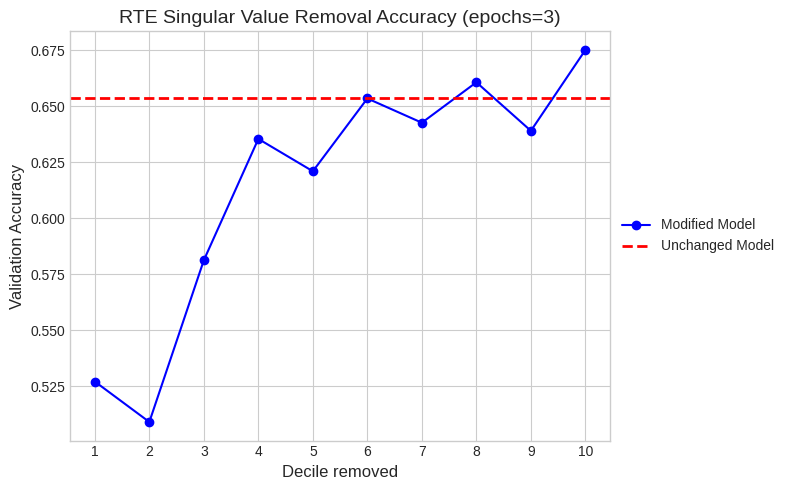

In [ ]:
plt.figure(figsize=(8, 5))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot
final_acc = 0.653430
plt.plot(range(1, len(accuracies3)+1), accuracies3, marker='o', label='Modified Model', color='blue')
plt.axhline(y=final_acc, color='red', linestyle='--', linewidth=2, label='Unchanged Model')

# Labels and formatting
plt.xlabel('Decile removed', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('RTE Singular Value Removal Accuracy (epochs=3)', fontsize=14)
plt.xticks(range(1, len(accuracies3)+1))
#plt.ylim(0., 1)

# Legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [ ]:
model1 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2
)

trainer1 = fine_tune_classification_model_rte(
    model1,
    tokenizer,
    train_data=rte_dataset["train"],
    dev_data=rte_dataset["validation"],
    num_epochs=1
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.656533,0.631769


In [ ]:
test_processed = rte_dataset['validation'].map(preprocess_rte, batched=True, fn_kwargs={'tokenizer': tokenizer})
accuracies1 = evaluate_decile_removal(
    control_model=trainer1.model,
    tokenizer=tokenizer,
    trainer_args=trainer1.args,
    compute_metrics=trainer1.compute_metrics,
    test_data=test_processed,
    model_checkpoint_name=model_checkpoint
)


=== Evaluating decile 0 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 0 Accuracy: 0.5271

=== Evaluating decile 1 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 1 Accuracy: 0.4729

=== Evaluating decile 2 removal ===


Decile 2 Accuracy: 0.4801

=== Evaluating decile 3 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 3 Accuracy: 0.5523

=== Evaluating decile 4 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 4 Accuracy: 0.5812

=== Evaluating decile 5 removal ===


Decile 5 Accuracy: 0.5921

=== Evaluating decile 6 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 6 Accuracy: 0.6282

=== Evaluating decile 7 removal ===


Decile 7 Accuracy: 0.5848

=== Evaluating decile 8 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 8 Accuracy: 0.6029

=== Evaluating decile 9 removal ===


Decile 9 Accuracy: 0.4838


In [ ]:
accuracies1

[0.5270758122743683,
 0.4729241877256318,
 0.48014440433212996,
 0.5523465703971119,
 0.5812274368231047,
 0.592057761732852,
 0.628158844765343,
 0.5848375451263538,
 0.6028880866425993,
 0.48375451263537905]

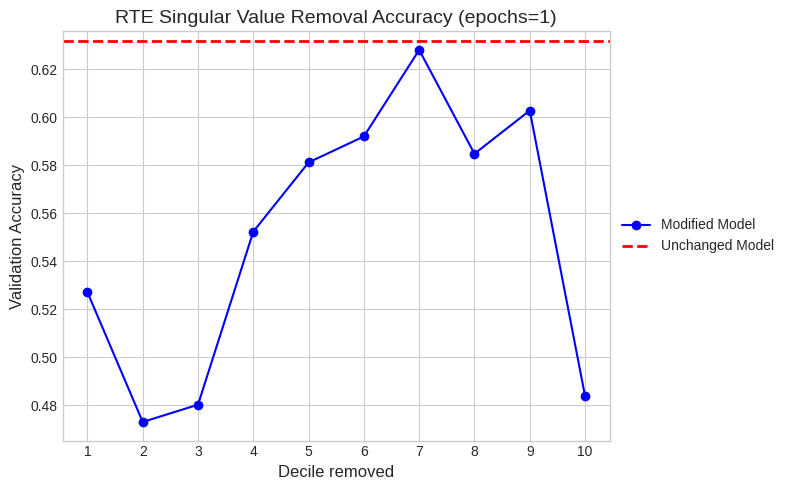

In [ ]:
plt.figure(figsize=(8, 5))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot
final_acc = 0.631769
plt.plot(range(1, len(accuracies1)+1), accuracies1, marker='o', label='Modified Model', color='blue')
plt.axhline(y=final_acc, color='red', linestyle='--', linewidth=2, label='Unchanged Model')

# Labels and formatting
plt.xlabel('Decile removed', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('RTE Singular Value Removal Accuracy (epochs=1)', fontsize=14)
plt.xticks(range(1, len(accuracies1)+1))
#plt.ylim(0., 1)

# Legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [ ]:
model2 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2
)

trainer2 = fine_tune_classification_model_rte(
    model2,
    tokenizer,
    train_data=rte_dataset["train"],
    dev_data=rte_dataset["validation"],
    num_epochs=2
)

test_processed = rte_dataset['validation'].map(preprocess_rte, batched=True, fn_kwargs={'tokenizer': tokenizer})
accuracies2 = evaluate_decile_removal(
    control_model=trainer2.model,
    tokenizer=tokenizer,
    trainer_args=trainer2.args,
    compute_metrics=trainer2.compute_metrics,
    test_data=test_processed,
    model_checkpoint_name=model_checkpoint
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.643976,0.653430
2,No log,0.624609,0.657040



=== Evaluating decile 0 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 0 Accuracy: 0.5235

=== Evaluating decile 1 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 1 Accuracy: 0.4729

=== Evaluating decile 2 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 2 Accuracy: 0.5199

=== Evaluating decile 3 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 3 Accuracy: 0.6137

=== Evaluating decile 4 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 4 Accuracy: 0.6354

=== Evaluating decile 5 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 5 Accuracy: 0.6570

=== Evaluating decile 6 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 6 Accuracy: 0.6534

=== Evaluating decile 7 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 7 Accuracy: 0.6354

=== Evaluating decile 8 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 8 Accuracy: 0.6426

=== Evaluating decile 9 removal ===


Decile 9 Accuracy: 0.5957


In [ ]:
accuracies2

[0.5234657039711191,
 0.4729241877256318,
 0.51985559566787,
 0.6137184115523465,
 0.6353790613718412,
 0.6570397111913358,
 0.6534296028880866,
 0.6353790613718412,
 0.6425992779783394,
 0.5956678700361011]

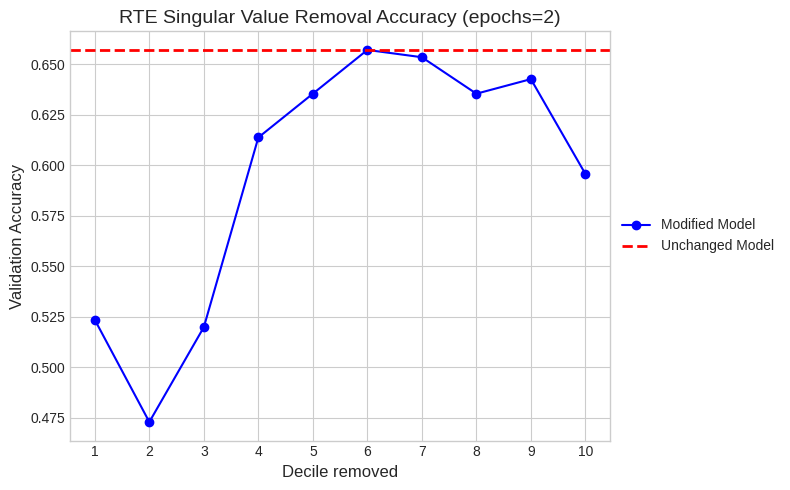

In [ ]:
plt.figure(figsize=(8, 5))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot
final_acc = 0.657040
plt.plot(range(1, len(accuracies2)+1), accuracies2, marker='o', label='Modified Model', color='blue')
plt.axhline(y=final_acc, color='red', linestyle='--', linewidth=2, label='Unchanged Model')

# Labels and formatting
plt.xlabel('Decile removed', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('RTE Singular Value Removal Accuracy (epochs=2)', fontsize=14)
plt.xticks(range(1, len(accuracies2)+1))
#plt.ylim(0., 1)

# Legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


In [ ]:
model10 = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2
)

trainer10 = fine_tune_classification_model_rte(
    model10,
    tokenizer,
    train_data=rte_dataset["train"],
    dev_data=rte_dataset["validation"],
    num_epochs=10
)

test_processed = rte_dataset['validation'].map(preprocess_rte, batched=True, fn_kwargs={'tokenizer': tokenizer})
accuracies10 = evaluate_decile_removal(
    control_model=trainer10.model,
    tokenizer=tokenizer,
    trainer_args=trainer10.args,
    compute_metrics=trainer10.compute_metrics,
    test_data=test_processed,
    model_checkpoint_name=model_checkpoint
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.647909,0.610108
2,No log,0.711581,0.657040
3,No log,0.861319,0.617329
4,0.529500,1.178451,0.649819
5,0.529500,1.330770,0.624549
6,0.529500,1.617437,0.649819
7,0.143900,2.061153,0.664260
8,0.143900,2.333895,0.649819
9,0.143900,2.430726,0.653430
10,0.035200,2.519190,0.660650



=== Evaluating decile 0 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 0 Accuracy: 0.5271

=== Evaluating decile 1 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 1 Accuracy: 0.5596

=== Evaluating decile 2 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 2 Accuracy: 0.6137

=== Evaluating decile 3 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 3 Accuracy: 0.6354

=== Evaluating decile 4 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 4 Accuracy: 0.6498

=== Evaluating decile 5 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 5 Accuracy: 0.6787

=== Evaluating decile 6 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 6 Accuracy: 0.6751

=== Evaluating decile 7 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 7 Accuracy: 0.6606

=== Evaluating decile 8 removal ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Decile 8 Accuracy: 0.6534

=== Evaluating decile 9 removal ===


Decile 9 Accuracy: 0.6426


In [ ]:
accuracies10

[0.5270758122743683,
 0.5595667870036101,
 0.6137184115523465,
 0.6353790613718412,
 0.6498194945848376,
 0.6787003610108303,
 0.6750902527075813,
 0.6606498194945848,
 0.6534296028880866,
 0.6425992779783394]

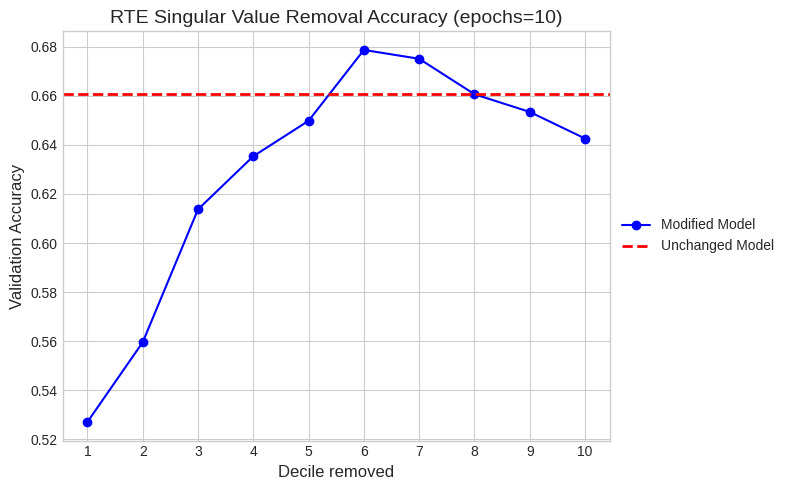

In [ ]:
plt.figure(figsize=(8, 5))
plt.style.use('seaborn-v0_8-whitegrid')

# Plot
final_acc = 0.653430
plt.plot(range(1, len(accuracies10)+1), accuracies10, marker='o', label='Modified Model', color='blue')
plt.axhline(y=0.660650, color='red', linestyle='--', linewidth=2, label='Unchanged Model')

# Labels and formatting
plt.xlabel('Decile removed', fontsize=12)
plt.ylabel('Validation Accuracy', fontsize=12)
plt.title('RTE Singular Value Removal Accuracy (epochs=10)', fontsize=14)
plt.xticks(range(1, len(accuracies10)+1))
#plt.ylim(0., 1)

# Legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


## Saving / Loading Models

In [ ]:
trainer.model.save_pretrained('./bert_fine_tuned_rte/')

In [ ]:
#loading in later
save_directory = './bert_fine_tuned_imdb'
model = AutoModelForSequenceClassification.from_pretrained(save_directory)

## Graphs

In [2]:
#copy and pasted from above...
base_imdb1 = 0.843000
base_imdb2 = 0.848000
base_imdb3 = 0.844000
base_imdb10 = 0.821000

base_rte1 = 0.631769
base_rte2 = 0.657040
base_rte3 = 0.653430
base_rte10 = 0.660650

In [3]:
def compute_degradation(base, acc_list):
    return [x - base for x in acc_list]

# IMDb data
base_imdb = [base_imdb1, base_imdb2, base_imdb3, base_imdb10]
acc_imdb = [accuracies_imdb1, accuracies_imdb2, accuracies_imdb3, accuracies_imdb10]

# RTE data
base_rte = [base_rte1, base_rte2, base_rte3, base_rte10]
acc_rte = [accuracies1, accuracies2, accuracies3, accuracies10]

degradation_imdb = [compute_degradation(b, a) for b, a in zip(base_imdb, acc_imdb)]
degradation_rte = [compute_degradation(b, a) for b, a in zip(base_rte, acc_rte)]

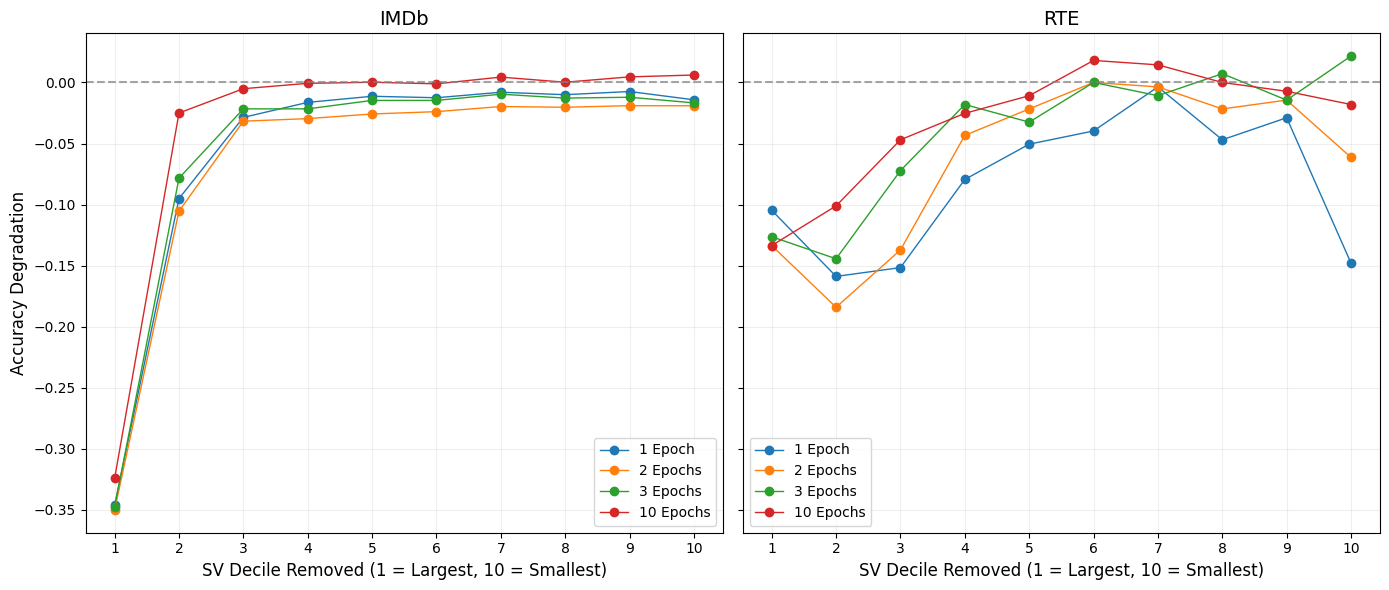

In [4]:
deciles = np.arange(1, 11)
epoch_labels = ['1 Epoch', '2 Epochs', '3 Epochs', '10 Epochs']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, orange, green, red

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# IMDb plot
for i, deg in enumerate(degradation_imdb):
    ax1.plot(deciles, deg, marker='o', color=colors[i], label=epoch_labels[i], linewidth=1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.7)
ax1.set_title('IMDb', fontsize=14)
ax1.set_xlabel('SV Decile Removed (1 = Largest, 10 = Smallest)', fontsize=12)
ax1.set_ylabel('Accuracy Degradation', fontsize=12)
ax1.grid(True, alpha=0.2)
ax1.set_xticks(deciles)
ax1.legend()

# RTE plot
for i, deg in enumerate(degradation_rte):
    ax2.plot(deciles, deg, marker='o', color=colors[i], label=epoch_labels[i], linewidth=1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.7)
ax2.set_title('RTE', fontsize=14)
ax2.set_xlabel('SV Decile Removed (1 = Largest, 10 = Smallest)', fontsize=12)
ax2.grid(True, alpha=0.2)
ax2.set_xticks(deciles)
ax2.legend()

plt.tight_layout()
plt.savefig('sv_degradation_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

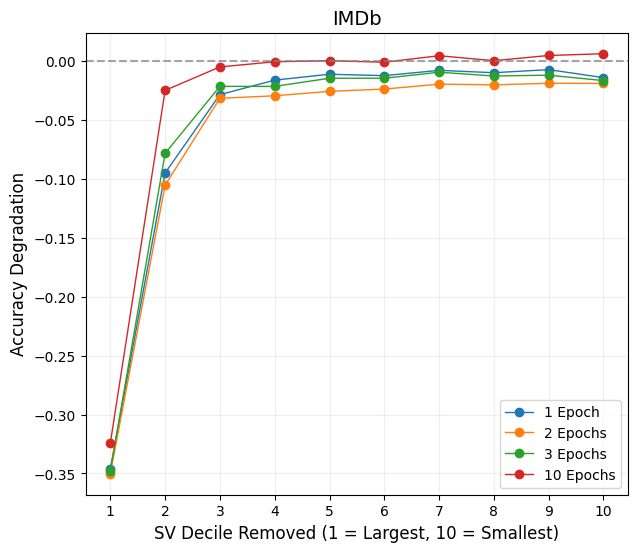

In [5]:
epoch_labels = ['1 Epoch', '2 Epochs', '3 Epochs', '10 Epochs']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, orange, green, red

fig, (ax1) = plt.subplots(1, 1, figsize=(7, 6), sharey=True)

# IMDb plot
for i, deg in enumerate(degradation_imdb):
    ax1.plot(deciles, deg, marker='o', color=colors[i], label=epoch_labels[i], linewidth=1)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.7)
ax1.set_title('IMDb', fontsize=14)
ax1.set_xlabel('SV Decile Removed (1 = Largest, 10 = Smallest)', fontsize=12)
ax1.set_ylabel('Accuracy Degradation', fontsize=12)
ax1.grid(True, alpha=0.2)
ax1.set_xticks(deciles)
ax1.legend()

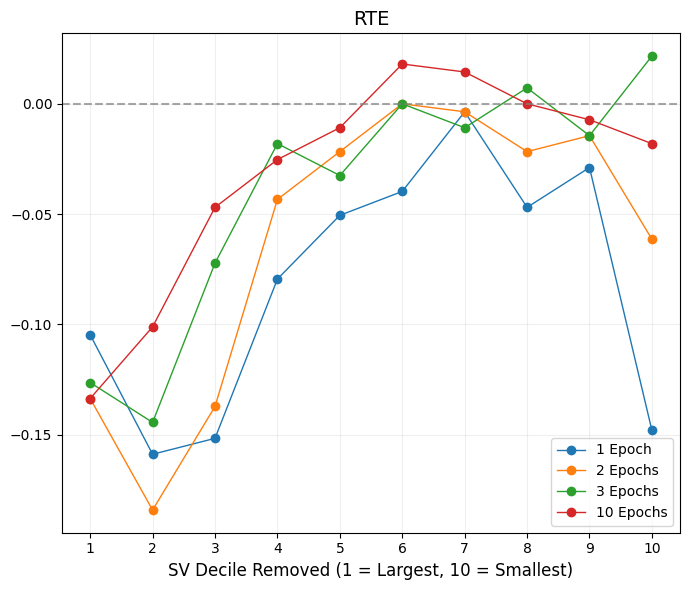

In [6]:
epoch_labels = ['1 Epoch', '2 Epochs', '3 Epochs', '10 Epochs']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, orange, green, red

fig, (ax2) = plt.subplots(1, 1, figsize=(7, 6), sharey=True)

# RTE plot
for i, deg in enumerate(degradation_rte):
    ax2.plot(deciles, deg, marker='o', color=colors[i], label=epoch_labels[i], linewidth=1)
ax2.axhline(0, color='gray', linestyle='--', alpha=0.7)
ax2.set_title('RTE', fontsize=14)
ax2.set_xlabel('SV Decile Removed (1 = Largest, 10 = Smallest)', fontsize=12)
ax2.grid(True, alpha=0.2)
ax2.set_xticks(deciles)
ax2.legend()

plt.tight_layout()
plt.show()